<a href="https://colab.research.google.com/github/Marei33/Deep-Learning/blob/main/Ex4_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise Sheet 4 - Transfer Learning for Saliency Prediction

 * Deep Learning
 * Instructor: Alexander Ecker
 * Tutors: Max Burg, Laura Pede
 * Due date: **Tue, Dec 21, noon**

In this assignment you will learn how to use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model pretrained on ImageNet.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.

## Hints

To understand the idea of the exercise sheet, inspired by a paper called DeepGaze I, do the following.

* Review the lecture
* Tt will be very helpful to read the according paper [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 

Although the general idea of the exercise will be the same, we changed some details: for example, we will use VGG instead of caffe net, will not do the same thoroughly analysis and changed some other details as well to make this exercise simpler.

*Do not hesitate to ask questions and ideally discuss them with your fellow students and tutors on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck. Also, we are happy to help in our office hours - looking forward seeing you there!*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.

**Importing required libraries.**

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from google.colab import drive
import fastprogress


In [102]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80


**Get the data**

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html

For your convenience there is a shared folder on Google Drive: https://drive.google.com/drive/folders/1GoYw3jp9kWLmHN7qylDS5QTo_ebnaMDD?usp=sharing
You can click the link and add the folder to your Drive (it does not count into your disk quota).

If you're using Colab, you can uncomment the code in the following cell to mount your Google drive. Otherwise, you need to download the data and enter the path to it.

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
main_path = "/content/drive/My Drive/Deep_Learning"
data_path = os.path.join(main_path, "MIT_1003")


**Prepare the data**

In [105]:
# creates a list of all pictures (if ending .jpeg) links (full link through drive) in the folder "ALLSTIMULI"
images_files_all = [
    os.path.join(data_path, "ALLSTIMULI", f)
    for f in os.scandir(os.path.join(data_path, "ALLSTIMULI"))
    if f.path.endswith(".jpeg")
]
print("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))


Total Number of Images: 1003 (should be 1003)


In [106]:
# fix the seed for reproducible splitting
np.random.seed(1234)
# generates a random sample from np.arange(len(images_files_all)9 with the size len(images_files_all) // 2 with no dublicates
train_idx = np.random.choice(len(images_files_all), len(images_files_all) // 2, replace=False)
# finds the difference  between np.arange(len(images_files_all)) and the train set train_idx, result is test set
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

# Creates a dict for the image files with a train and test key containing all image file links.
images_files = {}
images_files["train"] = [images_files_all[i] for i in train_idx]
images_files["test"] = [images_files_all[i] for i in test_idx]
print("Number of Train Images: {}".format(len(images_files["train"])))
print("Number of Test Images: {}".format(len(images_files["test"])))

# draws all visual fixation images for the training- and testset (ALLFIXATIONMAPS) with "_fixMap" at the end.
# The "_fixPts" Pictures somehow seem to all be black pictures.
fixation_maps_binary_files = {}
fixation_maps_binary_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["train"]
]
fixation_maps_binary_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["test"]
]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["train"]
]
fixation_maps_blurred_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["test"]
]


Number of Train Images: 501
Number of Test Images: 502


**Show an example from the dataset**

In [107]:
image = io.imread(images_files["train"][0])
binary_map = io.imread(fixation_maps_binary_files["train"][0])
blurred_map = io.imread(fixation_maps_blurred_files["train"][0])
fixations = np.where(binary_map) #needed to get the blue fixation points


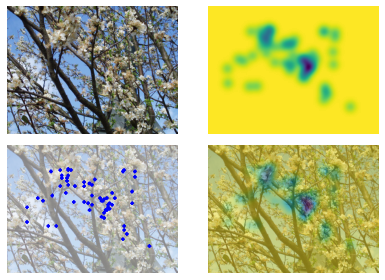

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis("off")
ax1.imshow(image)
ax2.axis("off")
ax2.imshow(blurred_map, cmap="viridis_r")
ax3.axis("off")
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker=".", c="b")
ax4.axis("off")
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
fig.tight_layout()


**Preprocess images and maps**

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [109]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    # Defines transform as a torchvision function that resizes and crops a picture
    # see on examples what the functions do: https://pytorch.org/vision/master/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(shape),
            torchvision.transforms.CenterCrop(shape),
        ]
    )

    # creates empty storage arrays
    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    # for each the image, the fix_binary_image as well as the fix_blurred_image it reads the path,
    # transforms the image , turns it into an array of type integer and adds it to the empty array defined before.
    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary

    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred

    data = {"images": ims, "fixations_binary": fixs_binary, "fixations_blurred": fixs_blurred}
    return data


In [110]:
# If data is already preprocessed and saved, load it, otherwise preprocess and save it.
# If you do not whish to save the data comment the according lines.
# If you want to re-run data preprocessing, you may have to delete the saved file.

train_data_file = os.path.join(main_path, "train_data.npy")

# if the training data file exists it is loaded
if os.path.isfile(train_data_file):
    train_data = np.load(train_data_file, allow_pickle=True)[()]
    # otherwise the preprocessing is done for the data and the results are saved using np.save (Save an array to a binary file in NumPy .npy format.)
else:
    train_data = preprocess_data(
        images_files["train"], fixation_maps_binary_files["train"], fixation_maps_blurred_files["train"], 256
    )
    np.save(train_data_file, train_data)


**Implement a PyTorch dataset for our data**

We need the `torch.utils.data.Dataset`  to access the data conveniently. Later, it is required to have access to the data through this class to build a Pytorch dataloader.

In [111]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data

    def __getitem__(self, key):
        raw_image = self.data["images"][key]

        normalized_image = raw_image.astype(np.float32) / 255.0  # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])  # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])  # divide by SD
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW

        fixations_binary = self.data["fixations_binary"][key]
        fixations_blurred = self.data["fixations_blurred"][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred,
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data

    def __len__(self):
        return len(self.data["images"])


The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [112]:
def to_sparse(x):
    """converts dense tensor x to sparse format"""
    x_typename = torch.typename(x).split(".")[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())


def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch]),
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data


**Compute center bias**

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We incorporate this bias into our model explicitly. 

**TO DO:** To compute the center bias, 
1. sum all the binary fixation maps, 
1. normalize by dividing through the maximum value
1. apply a Gaussian filter with standard deviation 10 to smooth the result
1. and compute the natural logarithm

*Hints:*
- Use the `ImageDataset` class to directly access the data; no pytorch data loader is required here.
- For Gaussian filtering, you can use `gaussian_filter` from `scipy.ndimage`

In [113]:
from scipy.ndimage import gaussian_filter

# Instantiate the pytorch dataset. (Note that although it contains the same data,
# as `train_data` above, the objects are different. Here, we could use `train_data`)
# instead of `dataset_train`, however, to build a pytorch dataloader later, we
# have to use the `dataset_train` object.

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data["fixations_binary"]


In [114]:
def compute_center_bias(image_array):
  """
  Calcualtes center bias by summung upe the images, dividing by the max value of the sum and running a gaussian filter with sigma=10.
  Note that we expant the dims of the array at the end in order for it to conform to the image standard of having 3 dimensions.
  """
  sum_array = np.zeros([256,256])

  for i in range(256):
    for j in range(256):
      sum_array[i,j] = image_array[:,i,j].sum()
    
  max_value = np.max(sum_array)
  normalized_array = sum_array / max_value
  center_bias = np.log(gaussian_filter(normalized_array, sigma=10))
  center_bias = np.expand_dims(center_bias, axis=0)

  return center_bias

In [115]:
# TODO
center_bias = compute_center_bias(fixations_binary)  # (should be 1 x 256 x 256)
center_bias.shape

(1, 256, 256)

Plot the result

Text(0.5, 1.0, 'Center bias')

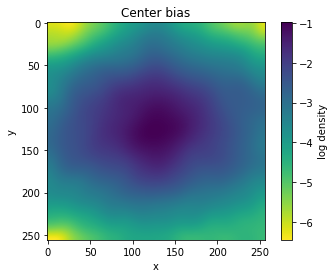

In [116]:
plt.figure()
plt.imshow(center_bias[0], cmap="viridis_r")
cb = plt.colorbar().set_label("log density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Center bias")


Your plot should look like this:

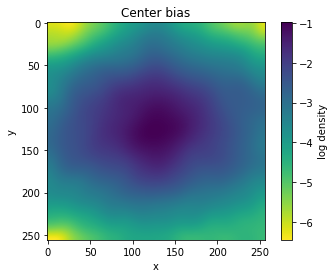

Save/Load center bias

In [117]:
center_bias_file = os.path.join(main_path, "center_bias.npy")

if os.path.isfile(center_bias_file):
    center_bias = np.load(center_bias_file)
else:
    np.save(center_bias_file, center_bias)


**Extract feature maps**

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the train dataset: For each image, extract its feature map representation from the Conv2d layer `vgg19.features[30]`. For that, you have to constraint the vgg19 model such that all it's layers up to (including) layer 30 process the image. The subsequent layers of the model are not required to extract the feature maps. You should save them in a Numpy array of shape `(num_feature_map_representations, num_channels, x, y)`.

**Theory question and hint**:
- Which shape do you expect for the numpy array? Calculate the values by hand
- You can verify that you calculated correctly with the code you will write for this task

*Hints:*
- Here you will have to define and use a pytorch `DataLoader` object
    - feed in the train set of type `torch.utils.data.Dataset` created above
    - use the `collate_fn` defined above
    - do not shuffle the images (i.e. the data points), so we can save the feature map representations of the images. That way, we can use the feature map representations later and still identify the according image we used to create them.
- cf. https://pytorch.org/docs/stable/torchvision/models.html. If you are wondering if we normalized images, check code in `ImageDataset`
- Define a `feature_extractor` object, containing those parts of the pre-trained VGG19 models that you need to textract the feature map representations from the Conv2d layer `vgg19.features[30]`
    - Don't forget to put your feature extractor in evaluation mode

In [119]:
# Downloading Pretrained Model 
vgg = models.vgg19(pretrained=True) #pretrained on imagenet: https://pytorch.org/vision/0.8/models.html
vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [120]:
# Printing all possible graph node names from which we can extract the features
# Guide to feature extraction. https://pytorch.org/blog/FX-feature-extraction-torchvision/

from torchvision.models.feature_extraction import get_graph_node_names
nodes, _ = get_graph_node_names(vgg)
print(nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [121]:
# Defining a feature extractor based on the guide above
from torchvision.models.feature_extraction import create_feature_extractor
feature_extractor = create_feature_extractor(
	vgg, return_nodes=['features.30']) # `out` will be a dict of Tensors, each representing a feature map

In [122]:
feature_extractor

VGG(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [123]:
from torch.utils.data import DataLoader
# Creating a DataLoader
data_loader = DataLoader(dataset_train, batch_size=1, shuffle=False, collate_fn=collate_fn,pin_memory = False)

In [124]:
def compute_train_features(data_loader, feature_extractor, input_key):

  features = np.empty((0,512,16,16), int)
  
  for image in iter(data_loader):
    features = np.append(features,
                         feature_extractor(image[input_key])['features.30'].detach().numpy(),
                         axis=0) 

  return features


**Save the features to a file**

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [125]:
features_file = os.path.join(main_path, "features_train.npy")

if os.path.isfile(features_file):
    features = np.load(features_file)

else:
    features = compute_train_features(data_loader, feature_extractor, 'image')

    # check if feature maps are computed correctly
    # fmt: off
    expected_values = np.array(
    [[ -7.99193907 ,  -9.97434425 ,  -6.30443621 ,  -5.38638353 ,  -4.27384281,
    -4.0693121  ,  -5.75616169 ,  -6.48476934 ,  -5.98380566 ,  -6.52242613],
    [-12.36434174 , -16.65618324 , -11.27461529 ,  -8.19952297 ,  -3.27289772,
    -1.19771433 ,  -3.19741416 ,  -6.47992802 ,  -6.5870204  ,  -7.18390512],
    [-11.13755226 , -15.65487099 , -12.64397049 ,  -7.71314335 ,  -2.45429325,
        0.83334196 ,  -0.64034951 ,  -5.03683281 ,  -4.65806484 ,  -4.50047112],
    [-10.5068655  , -14.42764664 , -10.61693573 ,  -5.19931602 ,  -1.12161112,
        0.89836073 ,  -0.5252769  ,  -3.71349239 ,  -2.97045493 ,  -2.79023504],
    [ -7.34475327 , -10.47937965 ,  -7.02888393 ,  -3.53863454 ,  -0.80185205,
    -0.74341547 ,  -1.12742841 ,  -2.42642498 ,  -2.1918633  ,  -2.38320088],
    [ -6.56508207 , -10.2462101  ,  -7.95301008 ,  -5.73207569 ,  -2.83811665,
    -3.51840949 ,  -3.68543339 ,  -3.03833508 ,  -3.84370446 ,  -3.34144878],
    [ -7.19058847 , -11.19171238 , -10.3939085  ,  -9.02087402 ,  -7.91058254,
    -8.43811989 ,  -7.81550455 ,  -6.3780117  ,  -7.06438923 ,  -4.87577438],
    [ -6.39207697 ,  -9.84247875 , -10.04116726 ,  -9.37077713 ,  -9.32631779,
    -8.01702595 ,  -8.88777161 ,  -7.13604116 ,  -6.65273285 ,  -4.70653677],
    [ -5.39928961 ,  -8.16330624 ,  -9.64505863 , -10.31910038 , -11.08797836,
    -9.06617165 ,  -8.1905756  ,  -7.1117115  ,  -5.28658915 ,  -3.31289601],
    [ -6.93690252 ,  -8.61090851 ,  -8.46377468 ,  -8.70087719 , -10.07951546,
    -9.06166553 ,  -7.16104031 ,  -6.44536161 ,  -4.36636829 ,  -1.53092551]]
    )
    # fmt: on
    assert np.allclose(features[0, 0, :10, :10], expected_values), "Feature maps look different than expected"

    np.save(features_file, features)


In [126]:
# The array has the correct dimensions e.g. (num_feature_map_representations, num_channels, x, y)
features.shape 

(501, 512, 16, 16)

Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [127]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False,
)

**Define the model**

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network

The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer

The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.

*Hints:*
- What are in- and out-shapes of the readout network? What are the parameters you have to pass to the constructor of the 1x1 convolution, then?
- Don't forget to give a learnable weight to the center bias, $\alpha$ in [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 
- In `Finalizer` below, initialize `self.gaussian_blur = GaussianBlur2d()` and use `self.gaussian_blur` in `forward(...)`.
- You might want to use `F.interpolate`
- The finalizer output is of shape `(batch, x_pixels, y_pixels)`
- Log softmax: As the finalizer should return the logarithm of the fixation probabilities, here is a hint rewriting the math of the paper cited above accordingly:
$$\ln p(x, y)=\ln \frac{\exp (o(x, y))}{\sum_{x, y} \exp (o(x, y))} = \ ?$$
(Note that in the paper $\log$ refers to the natural logarithm $\ln$. Ignore the regularization term in this step). Hence, we recommend you to use `logsumexp` to compute the softmax in log-space.

In [128]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """

    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape_x = [1] * 4
        kernel_shape_x[3] = self.kernel_size
        grid_x = nn.Parameter(grid.view(kernel_shape_x), requires_grad=False)
        self.kernel_x = torch.exp(-0.5 * (grid_x / self.sigma) ** 2)
        self.kernel_x = self.kernel_x / self.kernel_x.sum()

        kernel_shape_y = [1] * 4
        kernel_shape_y[2] = self.kernel_size
        grid_y = grid.view(kernel_shape_y)
        self.kernel_y = torch.exp(-0.5 * (grid_y / self.sigma) ** 2)
        self.kernel_y = self.kernel_y / self.kernel_y.sum()

    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        # added to devices to debug the run function
        out = F.conv1d(tensor, self.kernel_x.to(device), padding=self.pad)
        out = F.conv1d(out, self.kernel_y.to(device))

        return out


In [129]:
#TODO
class ReadOut(nn.Module):
  def __init__(self, num_channels=512):
    super(ReadOut, self).__init__()

    self.num_channels = num_channels
    self.conv_layer = nn.Conv2d(num_channels, 1, (1,1)) 
    #takes the weighted sum of each individual pixel through all 512 channel according to the weights in the kernel 
    #(same weights for each pixel)
    
  def forward(self, x):
    x = self.conv_layer(x)

    return x

readout_network = ReadOut()

In [130]:
# TODO
class Finalizer(nn.Module):
  """Returns logarithm of the fixation probability densities, shape: (batch, x_size, y_size)"""
  def __init__(self, num_channels=512):
    super(Finalizer, self).__init__()
    
    self.num_channels = num_channels
    self.gaussblurr = GaussianBlur2d()
    self.alpha = nn.Parameter(torch.tensor([0.1]),requires_grad = True).to(device) 
    

  def forward(self, x, center_bias):
    x = F.interpolate(x, size=(256,256))
    x = self.gaussblurr(x)
    x = x + self.alpha * center_bias
    tmp = torch.logsumexp(x, dim=(1,2,3)) # right dimensions here?
    x = torch.sub(x, tmp[:, None, None, None])
    # we take log sum exp over both dimensions to reduce x (256x256) to a number;
    # we then subtract from each component in x. 

    # Question: How to subtract a vector (that you want to expand) from a tensor in the correct dimension? 
    # How to subtract the same number from each image pixel?

    return x


In [131]:
class Model(nn.Module):
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer

    def forward(self, x, center_bias):
        x = self.readout_network(x)
        x = self.finalizer(x, center_bias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)


In [132]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)


**Define the metrics**

We use two different metrics, one for training and one for evaluating the performance of our model. Remember that we did this for the past exercises, too: back then, we used the cross-entropy loss for training and accuracy for validation.

Here, for the training, we use the negative log-likelihood (NLL). Implement a function that calculates the negative log-likelihood of a fixation mask (which are the labels in our data) under the model prediction `log_density` (i.e. the logarithm of the fixation probability density maps). 

*Hints:* 
The negative log-likelihood we want to use is a slight modification of the equation (last one on page 3) given in Kümmerer, Theis, and Bethge (2015): we ignore the regularization term. Hence, we obtain

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^{N} \ln \hat{p}\left(x_{i}, y_{i}\right) \ .$$

In this NLL we evaluate the model's predicted fixation probability $\hat{p}$ at the positions $(x_i,y_i)$ of each fixation $i \in \{1, ..., N\}$ measured in the experiments. Note that the elements in the binary fixation masks $f(x_j, y_k)$ (our labels) count how many fixations ocurred at position $(x_j, y_k)$.

Let's rewrite the NLL in a way you can directly implement into code: We compute the inner product of the model predictions at all spatial coordinates $\hat{p}(x_j, y_k)$ and ground truth binary fixation masks $f(x_j, y_k)$ and divide by the fixation count $N$. Additionally, we compute the mean over images $b$ in our batch. This way, we obtain

$$\tilde{c}(\alpha, w) = \frac{1}{b} \sum_b^B \underbrace{ (-1) \frac{1}{N} \sum_{j,k} \ln (\hat{p}(x_{j}, y_{k} |\, \mathrm{image} \ b)) \cdot f(x_{j},y_{k} |\, \mathrm{image} \ b) }_{c(\alpha, w)} \ .$$

**Questions:**
- Why can we re-write the expression $c(\alpha, w)$ like this? 
- What values can the elements of $f(x_{j},y_{k} |\, \mathrm{image} \ b)$ obtain?
- On the lecture slides the loss contained a *sum* over images. Here, for practical reasons we compute the *mean* over images instead. Why is that advantageous?

Implement $\tilde{c}(\alpha, w)$. You may want to
- Convert the sparse binary `fixation_mask` to a dense one using `t.to_dense()` to be able to compute the inner product of $f$ with the predictions $\hat{p}$.
- Compute the mean across batches

**Answers:**
- In the above equation we sum up the logarithms of the probabilities of all observed fixations. This is essentially the log likelihood as in the likelihood you multiply the probabilities of all observations (here features). In the modified equation we sum over all points of each picture (over j,k). At each point where we have an occurence or multiple ones  fj,k >= 1. Therefore we have the sum over the logarithms of the probabilities of the observed features as above. For all other points where we dont have any observations we have fj,k=0 and thus the loarithm of the probabilities at those points drop as they are multiplied by zero.
- I can obtain any natural number (0,1,2,3...) as it counts the number of times a person looked a a particular spot in a specific image.
- Whether we minimize the sum or the mean makes no difference as we only multiply by a scalar. Perhaps the mean has the advantage of being a smaller number thus easier to store? Furthermore it might make the loss comparable across models with a different number of images passed?


In [133]:
#TODO
def neg_log_likelihood(log_density, fixation_mask):
  
  fixation_mask = fixation_mask.to_dense().to(device)

  # Sparse and Dense Tensors:
  # - sparse tensors are a way to store tensors with lots of zeros, you specify indices where non-zeros are, then you specify the values that are there and you give the total tensor size, they look like this: torch.sparse_coo_tensor(torch.tensor([[1, 1],[0, 2]]),torch.tensor([9, 10]),size=(3, 3))
  # - dense tensors are the typical look of tensors as an array
  # here to continue to calculate with the tensor we need to change it from the spares to a dense format, hence .to_dense()

  batch_size = fixation_mask.shape[0]
  sum = 0

  for b in range(batch_size):
    N = fixation_mask[b].sum()
    inner_sum = (log_density[b] * fixation_mask[b]).sum()
    sum -= inner_sum/N

  nll = sum/batch_size

  return nll

For evaluation, we want to use the *normalized scanpath saliency* (NSS; [Peters, Iyer, Itti, and Koch (2005), Section 2.10](https://doi.org/10.1016/j.visres.2005.03.019)). To compute NSS, normalize the model's saliency map (prediction) $\mathrm{SM}(x,y)$ to have zero mean and unit standard deviation,

$$Z_{\mathrm{SM}}(x,y) = \frac{\mathrm{SM}(x,y) - \mu}{\sigma}\ ,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively. Then, average the according responses at all fixations $(x_i,y_i)$,

$$\mathrm{NSS} = \frac{1}{N} \sum_{i=1}^N Z_{\mathrm{SM}}(x_i,y_i)\ .$$ 

Implement this as a function.

*Hints:*
- Here, the saliency map $\mathrm{SM}(x,y)$ is *not* in log-space, i.e. the saliency map is given as exponential of the `log_density` that the model would predict, $\mathrm{e}^{\hat{p}(x, y)}$.
- Remember the hints from above: 
    - How can you rewrite/implement the sum over fixation points in terms of a inner product of the normlized saliency map and the binary fixation mask?
    - Compute the mean across batches

In [134]:
#TODO
def normalized_scanpath_saliency(log_density, fixation_mask): 
  #note: renamed function as to not confuse with variable nss
  fixation_mask = fixation_mask.to_dense()

  sm = torch.exp(log_density)
  mu = sm.mean(axis = (1,2,3))
  sigma = sm.std(axis = (1,2,3))

  sm = torch.sub(sm, mu[:, None, None, None])
  z = torch.div(sm, sigma[:, None, None, None])

  # batch size
  batch_size = log_density.shape[0]

  res = 0
  for i in range(batch_size):
    # fixation points in batch
    N = fixation_mask[i].sum()
    # compute nss for the whole batch
    tmp_nss = (z[i]*fixation_mask[i]).sum()
    # divide by all fixation points in batch
    res += tmp_nss/N

  res = res/batch_size
  return res

**Train the model**

Now iterate through the dataloader to train the model on the train dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the train dataset after each training epoch to monitor the progress. Train for at least 5 epochs. You are welcome to reuse and adapt the code you used on the previous exercise sheets for model training, but you don't have to.

*Hints:*
- Do we want to maximize or minimize the negative log-likelihood?
- In our reference implementation, after the fifth epoch we got `NLL: 10.0   NSS: 3.9`

In [135]:
def train(model, dataloader, optimizer, center_bias, device, master_bar):
  model.train()

  nll_epoch = np.array([])
  nss_epoch = np.array([])
  nll_save = np.array([])
  nss_save = np.array([])


  for x in fastprogress.progress_bar(dataloader, parent=master_bar):

    # delete the gradients from last training iteration
    optimizer.zero_grad()

    features = x["features"]
    fix = x["fixations_binary"]

    # Forward pass: get predictions
    log_ll = model(features.to(device), center_bias.to(device))


    # Compute loss
    nll = neg_log_likelihood(log_ll, fix)
    nll_save = np.append(nll_save, nll.cpu().detach().numpy())

    nss = normalized_scanpath_saliency(log_ll, fix.to(device))
    nss_save = np.append(nss_save, nss.cpu().detach().numpy())

    # Backward pass -> calculate gradients, update weights
    nll.backward()
    optimizer.step()

  # Calculate average loss (nll) and nss per epoch
  nll_epoch = nll_save.mean()
  nss_epoch = nss_save.mean()
        
  return nll_epoch, nss_epoch

In [136]:
from torch.types import Device
#TODO
def run_training(model, dataloader, center_bias=center_bias, num_epochs=5):
  device = get_device()

  model.to(device)
  # Question: Do we also need to move the individual objects of the model to the device? 
  # Or does this happen implicitly when the model is moved to the gpu?
  readout_network.to(device)
  finalizer.to(device)


  optimizer = optim.Adam(model.parameters())
  center_bias = torch.tensor(center_bias, dtype=torch.float).to(device)
  
  master_bar = fastprogress.master_bar(range(num_epochs))

  nll, nss = [],[]

  for epoch in master_bar:
    train_nll_epoch, train_nss_epoch = train(model, dataloader, optimizer, center_bias, device, master_bar)
    print(f"Epoch {epoch} \n Neg-LogLikelihood: {train_nll_epoch} \n NSS: {train_nss_epoch}")


    # Save losses and accuracies for plotting
    nll.append(train_nll_epoch)
    nss.append(train_nss_epoch)

        
  return nll, nss

In [137]:
nll, nss = run_training(model, data_loader_train, center_bias)

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80


Epoch 0 
 Neg-LogLikelihood: 11.196600916247043 
 NSS: 0.9498417750027806
Epoch 1 
 Neg-LogLikelihood: 10.652159258763454 
 NSS: 1.286178188780715
Epoch 2 
 Neg-LogLikelihood: 10.46634160478192 
 NSS: 1.4713483985550275
Epoch 3 
 Neg-LogLikelihood: 10.358977858072562 
 NSS: 1.63847821913552
Epoch 4 
 Neg-LogLikelihood: 10.298713396149706 
 NSS: 1.69057095101949


You can save the model to disk if you want to.

In [138]:
model_file = os.path.join(main_path, 'model_name.torch')

if os.path.isfile(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    %time run_training(model, data_loader_train, torch.tensor(center_bias, dtype=torch.float))
    torch.save(model.state_dict(), model_file)

# get the scores for the test data

In [139]:
from IPython.core.display import Image
test_data = preprocess_data(
    images_files["test"], fixation_maps_binary_files["test"], fixation_maps_blurred_files["test"], 256
)

test_dataset = ImageDataset(test_data)

100%|██████████| 502/502 [00:05<00:00, 96.43it/s]


Here you need to extract the same feature maps as you extracted before, but now for the test images instead of the trining images. It works the same way as before for the train dataset.

In [140]:
# TODO
def compute_test_features(testdata_loader, feature_extractor, input_key):

  features_test = np.empty((0,512,16,16), int)

  for image in iter(testdata_loader):
    features_test = np.append(features_test,
                         feature_extractor(image[input_key])['features.30'].detach().numpy(),
                         axis=0) 

  return features_test


save / load

In [141]:
test_dataloader= DataLoader(test_dataset, 
                            batch_size=1, 
                            shuffle = False, 
                            collate_fn = collate_fn,
                            pin_memory = False)

In [142]:
features_test_file = os.path.join(main_path, "features_test.npy")

if os.path.isfile(features_test_file):
    features_test = np.load(features_test_file)
else:
    features_test = compute_test_features(testdata_loader = test_dataloader, 
                                          feature_extractor = feature_extractor,
                                          input_key = "image")
    np.save(features_test_file, features_test)


Get the NSS scores for each test image. Print the three highest NSS scores. In our reference implementation, we got `[6.0, 7.1, 7.3]`.

In [143]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=1,
    collate_fn=collate_fn,
    pin_memory=False,
)

In [144]:
nss_list = []
log_ll_list = []

model.eval()
for i in iter(data_loader_test):
  log_ll = model(i["features"].to(device), torch.tensor(center_bias, dtype=torch.float).to(device))
  nss_tmp = normalized_scanpath_saliency(log_ll, i["fixations_binary"].to(device))

  nss_list.append(nss_tmp.detach().cpu().numpy())
  log_ll_list.append(log_ll)

**Inspect the results**

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

In [145]:
sorted_nss = np.sort(nss_list)

print(f"Three highest NSS scores: {sorted_nss[-4:-1]}")
print(f"Three lowest NSS scores: {sorted_nss[:3]}")

Three highest NSS scores: [4.68595548 5.04498111 5.2639787 ]
Three lowest NSS scores: [-0.10512966 -0.08920583  0.01454052]


**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is an example:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [146]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

    ax1.axis("off")
    ax1.imshow(image)
    ax1.set_title("original image")

    ax2.axis("off")
    ax2.imshow(blurred_map, cmap="viridis_r")
    ax2.set_title("blurred fixation map")

    ax3.axis("off")
    ax3.imshow(prediction, cmap="viridis_r")
    ax3.set_title("model prediction")

    ax4.axis("off")
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker=".", c="b")
    ax4.set_title("overlayed with discrete fixations")

    ax5.axis("off")
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
    ax5.set_title("overlayed with original image")

    ax6.axis("off")
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap="viridis_r")
    ax6.set_title("overlayed with original image")


In [147]:
best_ones = np.argsort(nss_list)[-4:-1]
worst_ones =  np.argsort(nss_list)[:3]

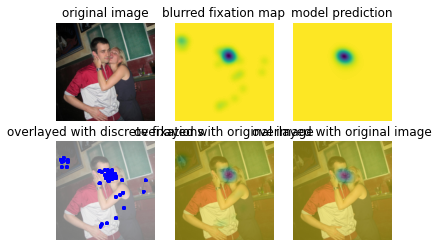

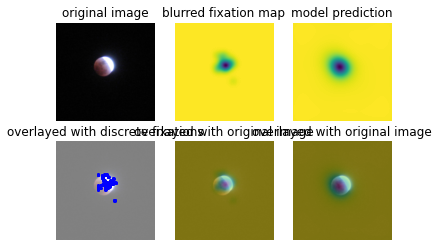

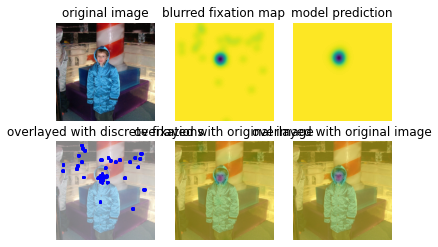

In [148]:
for idx_best in best_ones:
  image = dataset_test.data["images"][idx_best]
  binary_map = dataset_test.data["fixations_binary"][idx_best]
  fixation = np.where(binary_map)
  fixation_blurred = dataset_test.data["fixations_blurred"][idx_best]
  pred = torch.squeeze(log_ll_list[idx_best].detach().cpu())
  pred = torch.exp(pred)

  plot(image, fixation, fixation_blurred, pred)

**Display test images with lowest scores**

Here is an example for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

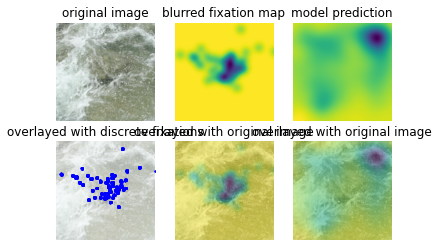

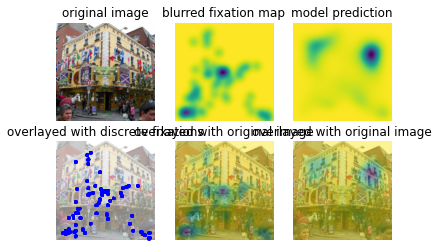

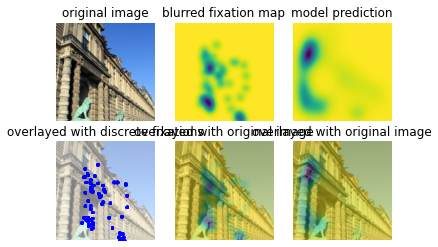

In [149]:
for idx_best in worst_ones:
  image = dataset_test.data["images"][idx_best]
  binary_map = dataset_test.data["fixations_binary"][idx_best]
  fixation = np.where(binary_map)
  fixation_blurred = dataset_test.data["fixations_blurred"][idx_best]
  pred = torch.squeeze(log_ll_list[idx_best].detach().cpu())
  pred = torch.exp(pred)

  plot(image, fixation, fixation_blurred, pred)